## Packages

In [154]:
import pandas as pd
import numpy as np

from scipy.stats import norm
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder
import tensorflow as tf
from scipy import stats
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error, make_scorer
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Read Data

In [68]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
print("Full train dataset shape is {}".format(df_train.shape))
print("Full test dataset shape is {}".format(df_test.shape))

Full train dataset shape is (1460, 81)
Full test dataset shape is (1459, 80)


In [69]:
##display the first five rows of the train dataset.
df_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [70]:
#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)
print("Full train dataset shape is {}".format(df_train.shape))
print("Full train dataset shape is {}".format(df_test.shape))

Full train dataset shape is (1460, 80)
Full train dataset shape is (1459, 79)


In [71]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## Exploratory Analysis

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
Skewness: 1.882876
Kurtosis: 6.536282


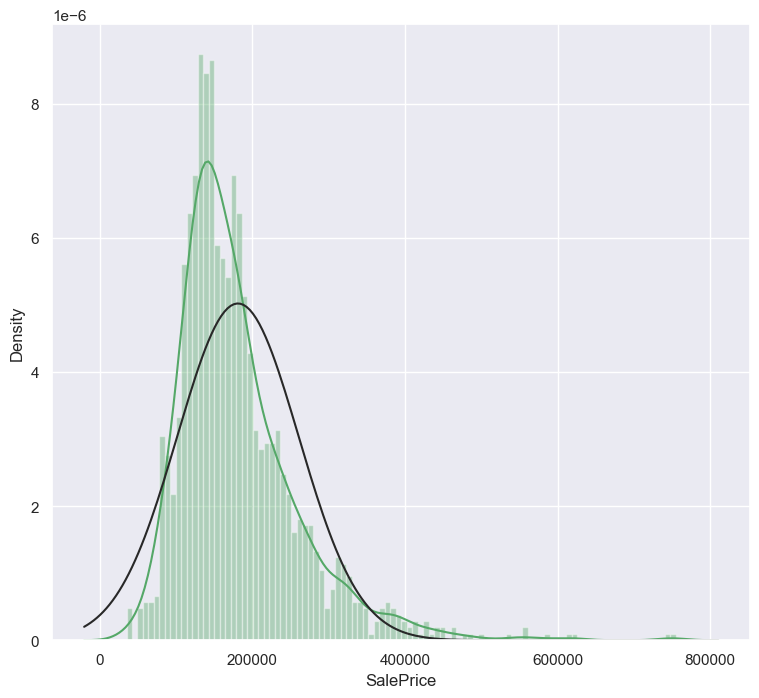

In [72]:
#descriptive statistics summary
print(df_train['SalePrice'].describe())


plt.figure(figsize=(9, 8))
sns.distplot(df_train['SalePrice'], fit=norm, color='g', bins=100, hist_kws={'alpha': 0.4});

#skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

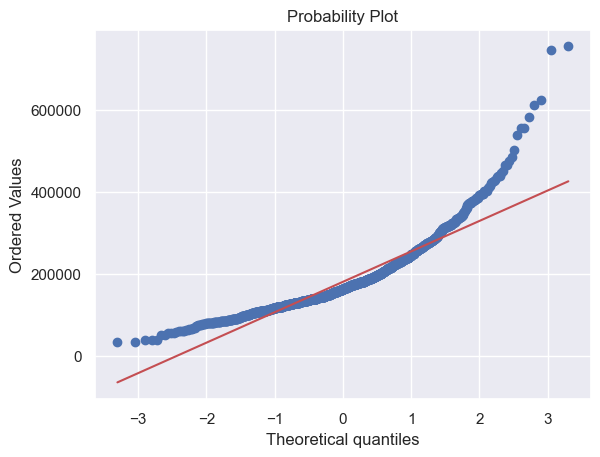

In [73]:
stats.probplot(df_train['SalePrice'], plot=plt);

* *<b>Deviate from the normal distribution.</b>*
* *<b>Have appreciable positive skewness.</b>*
* *<b>Show peakedness.</b>*

'SalePrice' is not normal. It shows 'peakedness', positive skewness and does not follow the diagonal line.

But everything's not lost. A simple data transformation can solve the problem. In case of positive skewness, log transformations usually works well.

In [74]:
list(set(df_train.dtypes.tolist()))

[dtype('float64'), dtype('int64'), dtype('O')]

In [75]:
df_num = df_train.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


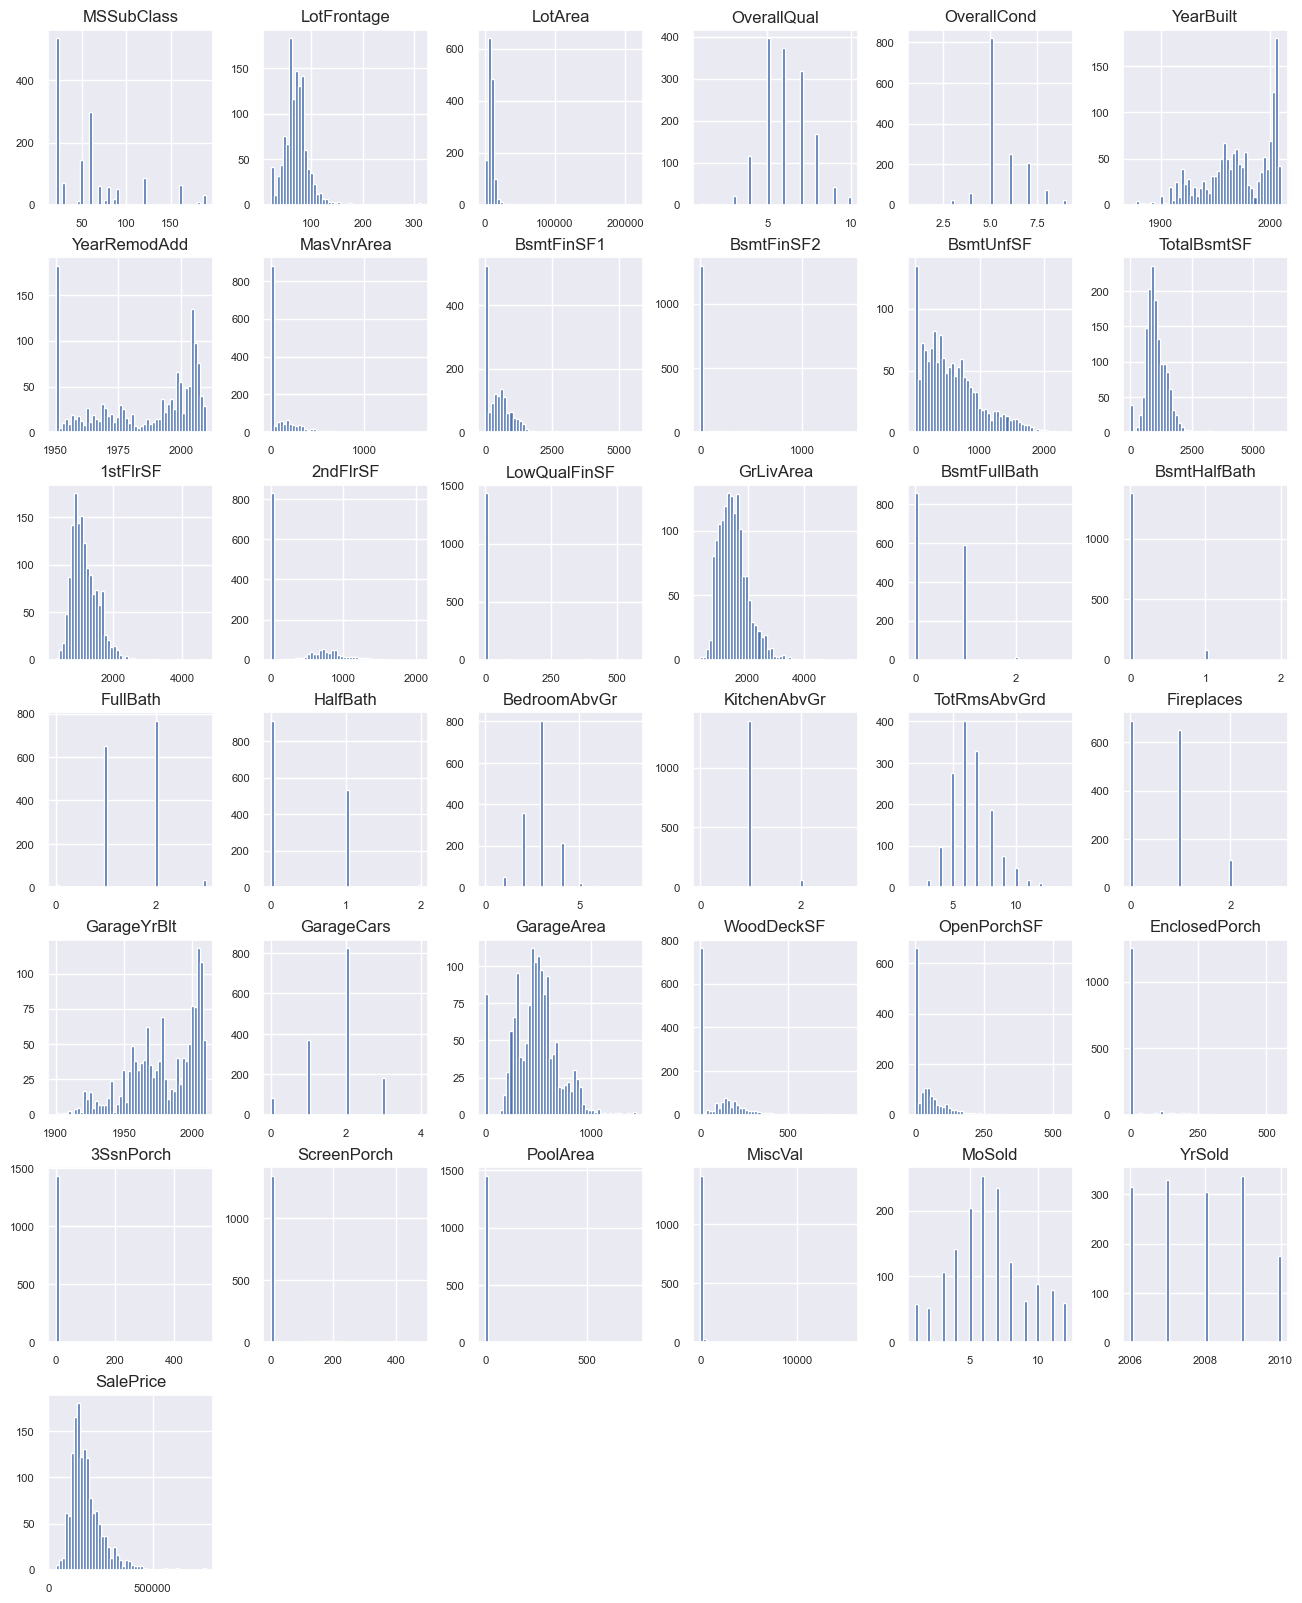

In [76]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

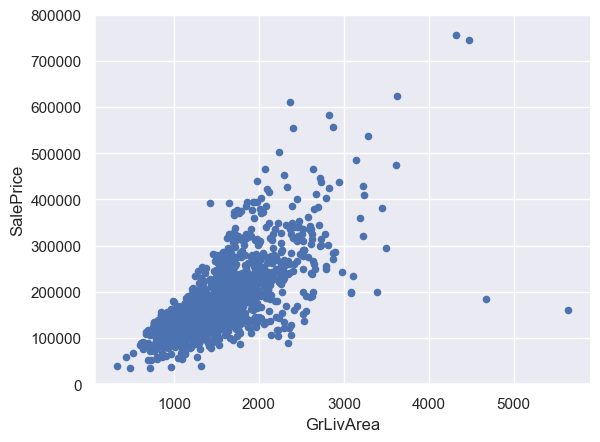

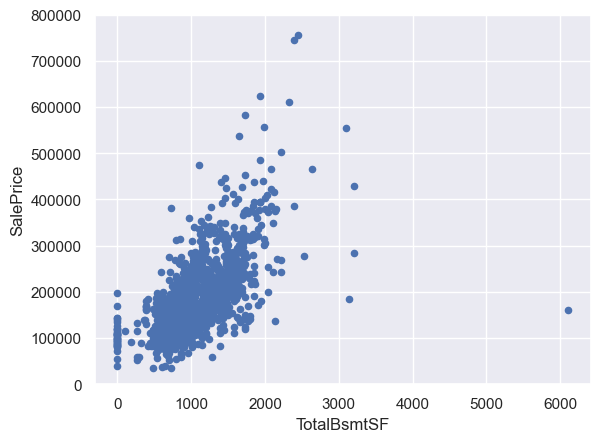

In [77]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));


#scatter plot totalbsmtsf/saleprice
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

We can see at the bottom right two with extremely large GrLivArea that are of a low price. These values are huge oultliers.
Therefore, we can safely delete them.

We decided to delete these two as they are very huge and  really  bad ( extremely large areas for very low  prices). 

There are probably others outliers in the training data.   However, removing all them  may affect badly our models if ever there were also  outliers  in the test data. That's why , instead of removing them all, we will just manage to make some of our  models robust on them. You can refer to  the modelling part of this notebook for that. 

In [78]:
#Deleting outliers
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<500000)].index)
df_train = df_train.drop(df_train[(df_train['TotalBsmtSF']>5000) & (df_train['SalePrice']<500000)].index)

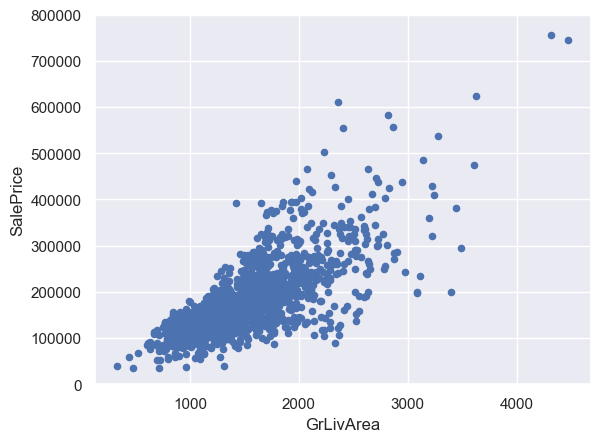

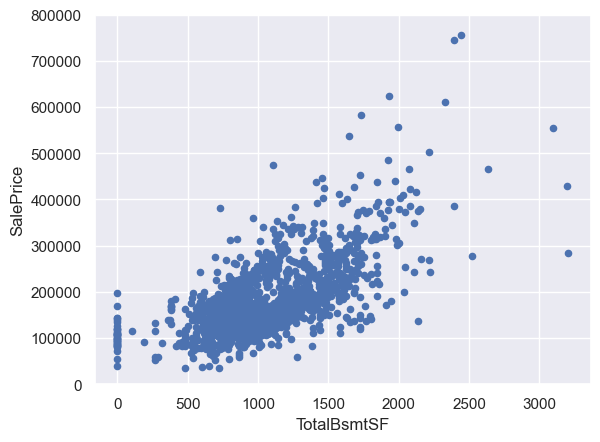

In [79]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));


#scatter plot totalbsmtsf/saleprice
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

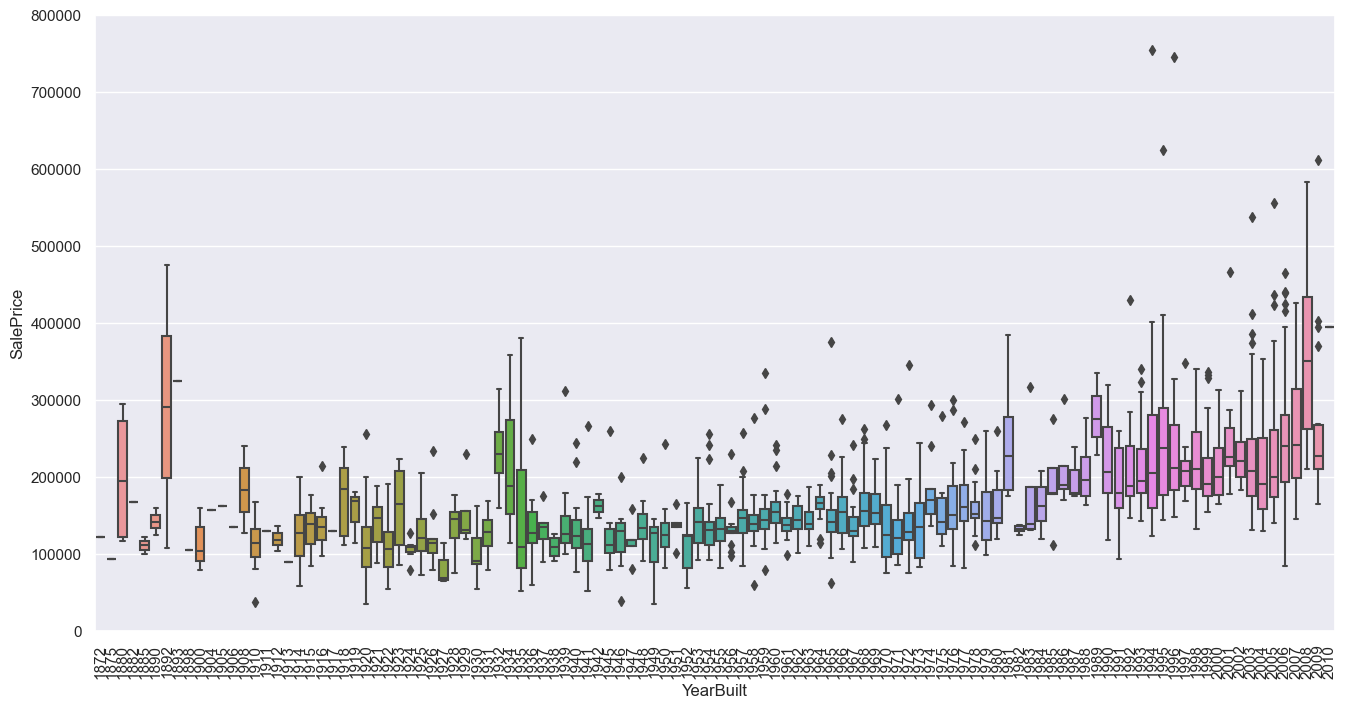

In [80]:
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

*Although it's not a strong tendency, I'd say that 'SalePrice' is more prone to spend more money in new stuff than in old relics.*

<b>Note</b>: we don't know if 'SalePrice' is in constant prices. Constant prices try to remove the effect of inflation. If 'SalePrice' is not in constant prices, it should be, so than prices are comparable over the years.

### In summary

Stories aside, we can conclude that:

* 'GrLivArea' and 'TotalBsmtSF' seem to be linearly related with 'SalePrice'. Both relationships are positive, which means that as one variable increases, the other also increases. In the case of 'TotalBsmtSF', we can see that the slope of the linear relationship is particularly high.
* 'OverallQual' and 'YearBuilt' also seem to be related with 'SalePrice'. The relationship seems to be stronger in the case of 'OverallQual', where the box plot shows how sales prices increase with the overall quality.

We just analysed four variables, but there are many other that we should analyse. The trick here seems to be the choice of the right features (feature selection) and not the definition of complex relationships between them (feature engineering).

That said, let's separate the wheat from the chaff.

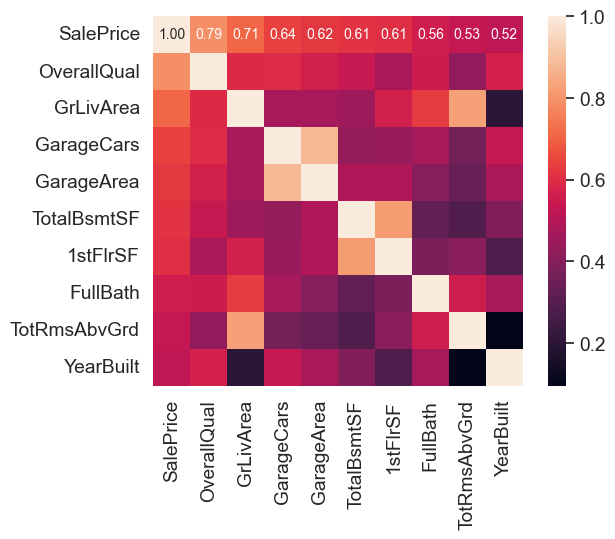

In [81]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
corrmat = df_num.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_num[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

These are the variables most correlated with 'SalePrice'. My thoughts on this:

* 'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'.
* 'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables. However, as we discussed in the last sub-point, the number of cars that fit into the garage is a consequence of the garage area. 'GarageCars' and 'GarageArea' are like twin brothers. You'll never be able to distinguish them. Therefore, we just need one of these variables in our analysis (we can keep 'GarageCars' since its correlation with 'SalePrice' is higher).
* 'TotalBsmtSF' and '1stFloor' also seem to be twin brothers. We can keep 'TotalBsmtSF'.
* 'FullBath'?? Really? 
* 'TotRmsAbvGrd' and 'GrLivArea', twin brothers again. Correlation is so strong that it can indicate a situation of multicollinearity. If we think about these variables, we can conclude that they give almost the same information so multicollinearity really occurs.
* 'YearBuilt': It seems that 'YearBuilt' is slightly correlated with 'SalePrice'. Honestly, it scares me to think about 'YearBuilt' because I start feeling that we should do a little bit of time-series analysis to get this right. 

Let's proceed to the scatter plots.

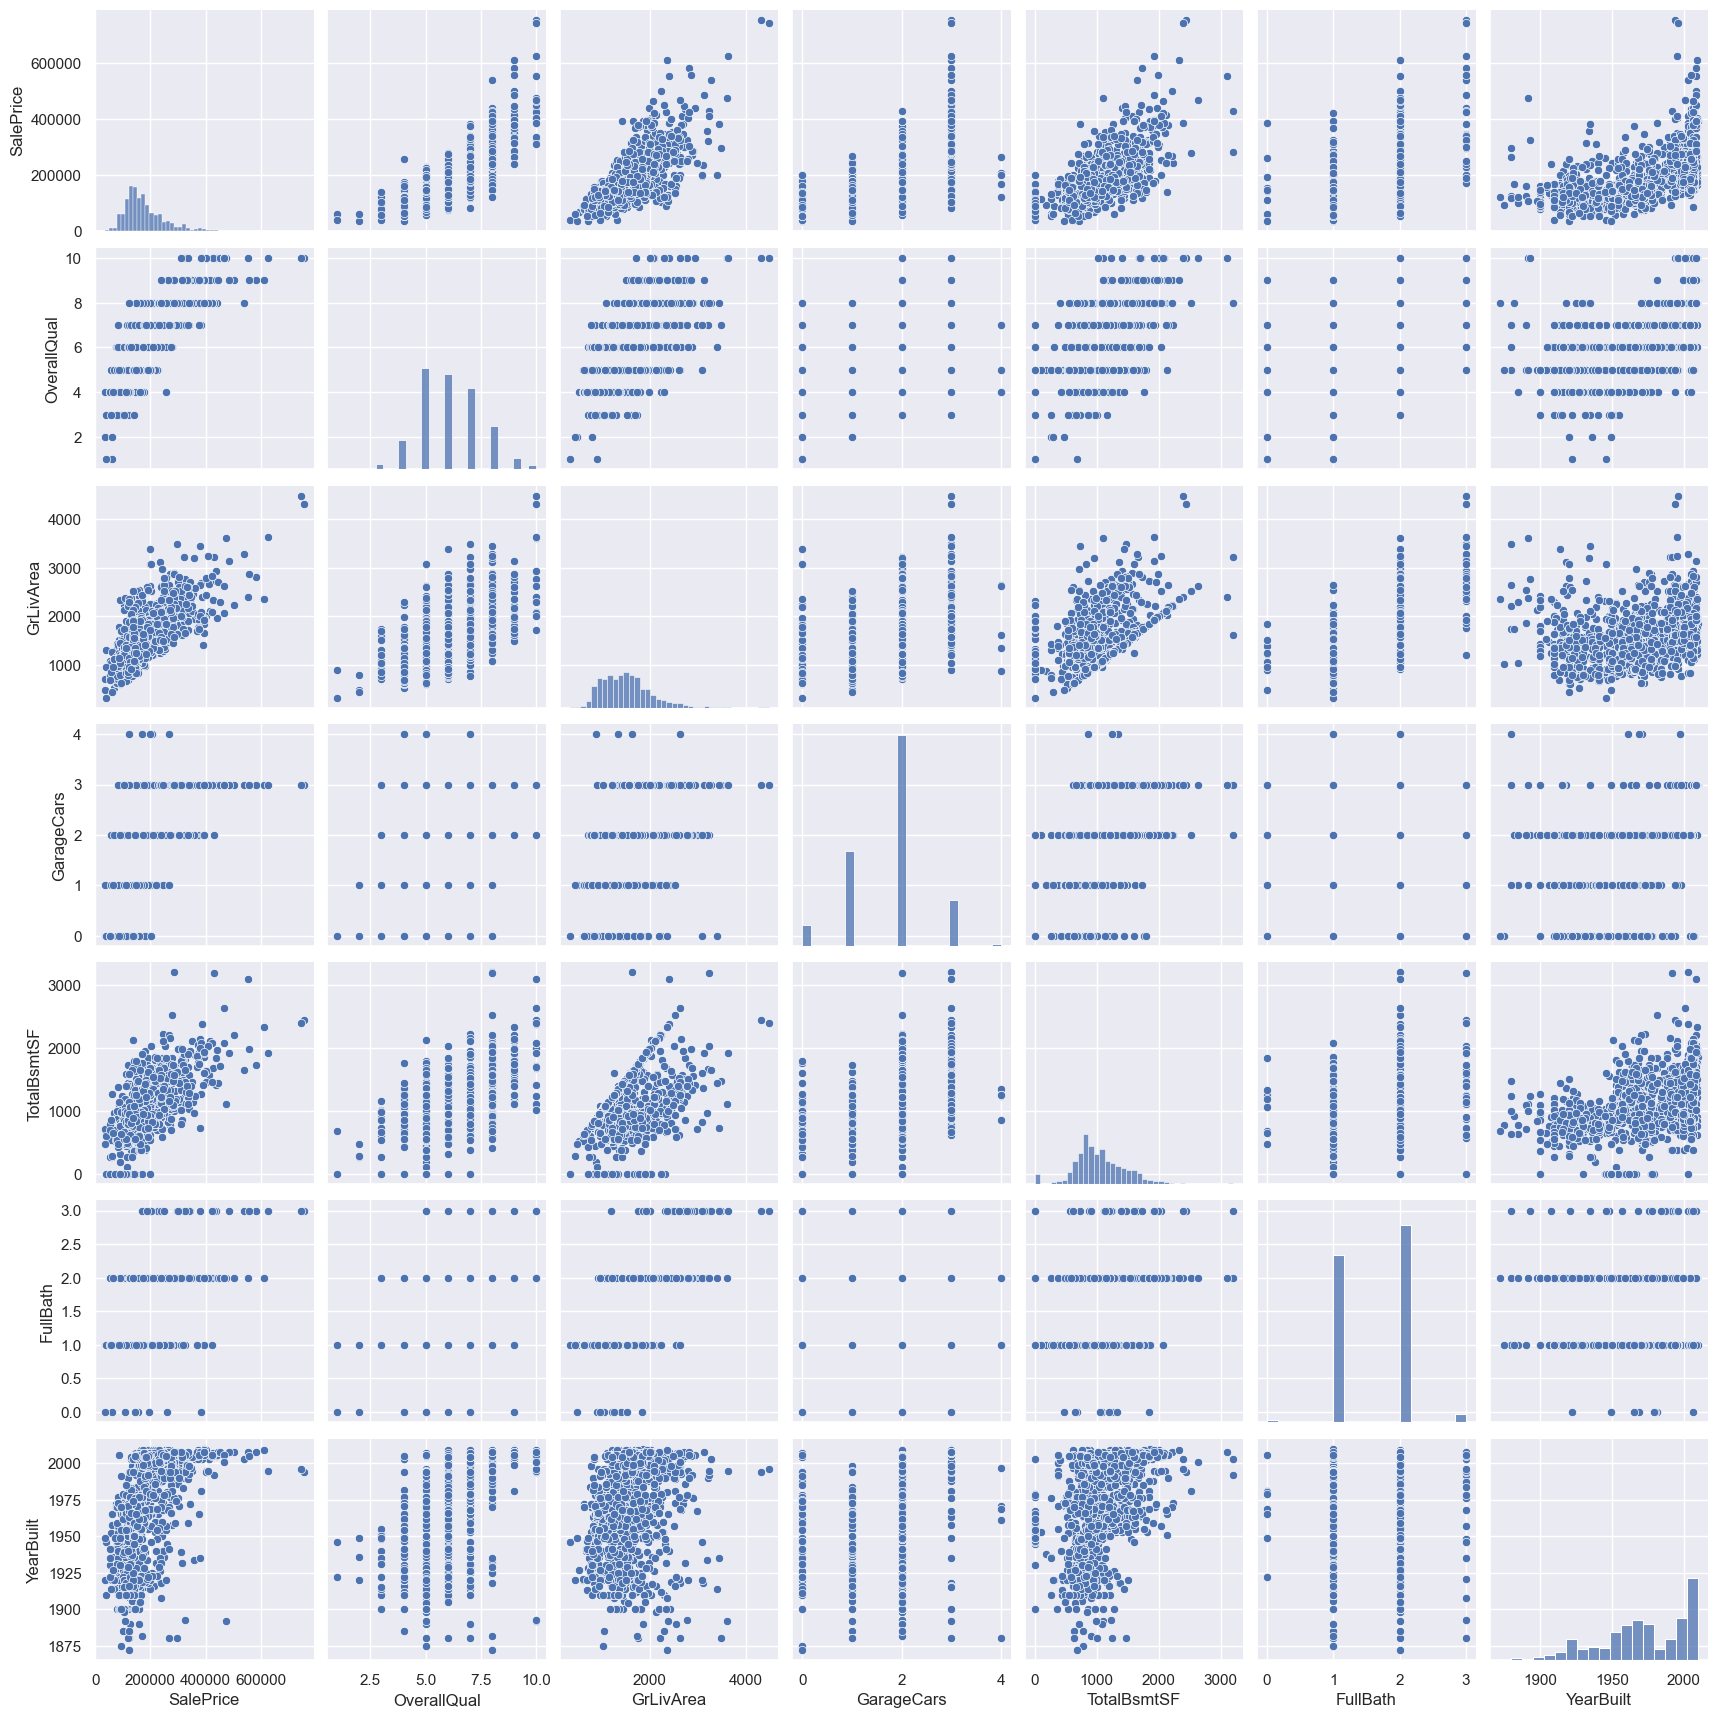

In [82]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

## Missing data

Important questions when thinking about missing data:

* How prevalent is the missing data?
* Is missing data random or does it have a pattern?

The answer to these questions is important for practical reasons because missing data can imply a reduction of the sample size. This can prevent us from proceeding with the analysis. Moreover, from a substantive perspective, we need to ensure that the missing data process is not biased and hidding an inconvenient truth.

In [83]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1452,0.995885
MiscFeature,1404,0.962963
Alley,1367,0.937586
Fence,1177,0.807270
MasVnrType,872,0.598080
FireplaceQu,690,0.473251
LotFrontage,259,0.177641
GarageYrBlt,81,0.055556
GarageCond,81,0.055556
GarageType,81,0.055556


Text(0.5, 1.0, 'Percent missing data by feature')

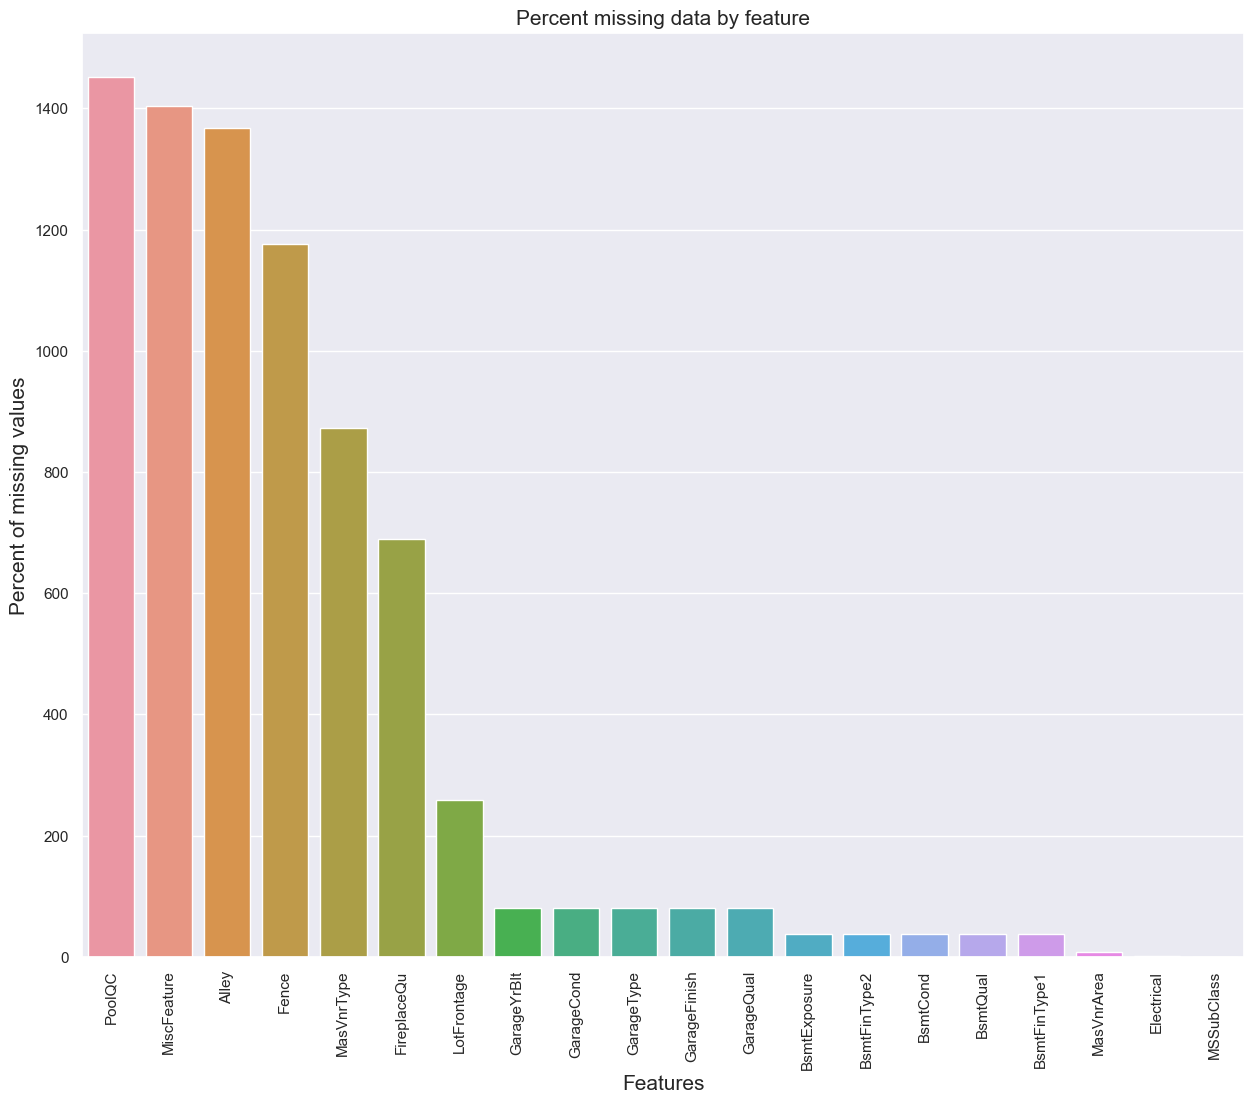

In [84]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation=90)
sns.barplot(x=missing_data.head(20).index, y=missing_data['Total'].head(20))
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

We'll consider that when more than 15% of the data is missing, we should delete the corresponding variable and pretend it never existed. This means that we will not try any trick to fill the missing data in these cases. According to this, there is a set of variables (e.g. 'PoolQC', 'MiscFeature', 'Alley', etc.) that we should delete. The point is: will we miss this data? I don't think so. None of these variables seem to be very important, since most of them are not aspects in which we think about when buying a house (maybe that's the reason why data is missing?). Moreover, looking closer at the variables, we could say that variables like 'PoolQC', 'MiscFeature' and 'FireplaceQu' are strong candidates for outliers, so we'll be happy to delete them.

In what concerns the remaining cases, we can see that 'Garage*X*' variables have the same number of missing data. I bet missing data refers to the same set of observations (although I will not check it; it's just 5% and we should not spend 20$ in 5$ problems). Since the most important information regarding garages is expressed by 'GarageCars' and considering that we are just talking about 5% of missing data, I'll delete the mentioned 'Garage*X*' variables. The same logic applies to 'Bsmt*X*' variables.

Regarding 'MasVnrArea' and 'MasVnrType', we can consider that these variables are not essential. Furthermore, they have a strong correlation with 'YearBuilt' and 'OverallQual' which are already considered. Thus, we will not lose information if we delete 'MasVnrArea' and 'MasVnrType'.

Finally, we have one missing observation in 'Electrical'. Since it is just one observation, we'll delete this observation and keep the variable.

In summary, to handle missing data, we'll delete all the variables with missing data, except the variable 'Electrical'. In 'Electrical' we'll just delete the observation with missing data.

In [85]:
# Dealing with missing data
missing_data = missing_data[missing_data['Total'] > 259]
df_train = df_train.drop(missing_data.index, axis=1)

# Just checking that there's no missing data missing...
df_train.isnull().sum().max()

259

- **LotFrontage** : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can **fill in missing values by the median LotFrontage of the neighborhood**.

In [86]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
df_train["LotFrontage"] = df_train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

- **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath** : missing values are likely zero for having no basement

In [87]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df_train[col] = df_train[col].fillna(0)

- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : For all these categorical basement-related features, NaN means that there is no  basement.

In [88]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df_train[col] = df_train[col].fillna('None')

- **MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type. 

In [89]:
#df_train["MasVnrType"] = df_train["MasVnrType"].fillna("None")
df_train["MasVnrArea"] = df_train["MasVnrArea"].fillna(0)

- **GarageType, GarageFinish, GarageQual and GarageCond** : Replacing missing data with None

In [90]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df_train[col] = df_train[col].fillna('None')

- **GarageYrBlt, GarageArea and GarageCars** : Replacing missing data with 0 (Since No garage = no cars in such garage.)

In [91]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df_train[col] = df_train[col].fillna(0)

- **Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.

In [92]:
df_train['Electrical'] = df_train['Electrical'].fillna(df_train['Electrical'].mode()[0])

**Adding one more important feature**

Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [93]:
# Adding total sqfootage feature 
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']

In [94]:
# Just checking that there's no missing data missing...
print(df_train.isnull().sum().max())
print("Full train dataset shape is {}".format(df_train.shape))

0
Full train dataset shape is (1458, 75)


**Transforming some numerical variables that are really categorical**

In [95]:
#MSSubClass=The building class
df_train['MSSubClass'] = df_train['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
df_train['OverallCond'] = df_train['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
df_train['YrSold'] = df_train['YrSold'].astype(str)
df_train['MoSold'] = df_train['MoSold'].astype(str)

**Label Encoding some categorical variables that may contain information in their ordering set**

In [96]:
cols = ('BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df_train[c].values)) 
    df_train[c] = lbl.transform(list(df_train[c].values))

In [97]:
df_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF
0,9,RL,65.0,8450,1,3,Lvl,AllPub,Inside,0,...,0,0,0,0,4,2,WD,Normal,208500,2566
1,4,RL,80.0,9600,1,3,Lvl,AllPub,FR2,0,...,0,0,0,0,7,1,WD,Normal,181500,2524
2,9,RL,68.0,11250,1,0,Lvl,AllPub,Inside,0,...,0,0,0,0,11,2,WD,Normal,223500,2706
3,10,RL,60.0,9550,1,0,Lvl,AllPub,Corner,0,...,0,0,0,0,4,0,WD,Abnorml,140000,2473
4,9,RL,84.0,14260,1,0,Lvl,AllPub,FR2,0,...,0,0,0,0,3,2,WD,Normal,250000,3343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,9,RL,62.0,7917,1,3,Lvl,AllPub,Inside,0,...,0,0,0,0,10,1,WD,Normal,175000,2600
1456,4,RL,85.0,13175,1,3,Lvl,AllPub,Inside,0,...,0,0,0,0,4,4,WD,Normal,210000,3615
1457,10,RL,66.0,9042,1,3,Lvl,AllPub,Inside,0,...,0,0,0,2500,7,4,WD,Normal,266500,3492
1458,4,RL,68.0,9717,1,3,Lvl,AllPub,Inside,0,...,0,0,0,0,6,4,WD,Normal,142125,2156


In [98]:
# shape        
print('Shape df_train: {}'.format(df_train.shape))

Shape df_train: (1458, 75)


In [99]:
all_data = pd.get_dummies(df_train)
print(all_data.shape)
all_data

(1458, 210)


,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,9,65.0,8450,1,3,0,7,4,2003,2003,...,False,False,False,True,False,False,False,False,True,False
1,4,80.0,9600,1,3,0,6,7,1976,1976,...,False,False,False,True,False,False,False,False,True,False
2,9,68.0,11250,1,0,0,7,4,2001,2002,...,False,False,False,True,False,False,False,False,True,False
3,10,60.0,9550,1,0,0,7,4,1915,1970,...,False,False,False,True,True,False,False,False,False,False
4,9,84.0,14260,1,0,0,8,4,2000,2000,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,9,62.0,7917,1,3,0,6,4,1999,2000,...,False,False,False,True,False,False,False,False,True,False
1456,4,85.0,13175,1,3,0,6,5,1978,1988,...,False,False,False,True,False,False,False,False,True,False
1457,10,66.0,9042,1,3,0,7,8,1941,2006,...,False,False,False,True,False,False,False,False,True,False
1458,4,68.0,9717,1,3,0,5,5,1950,1996,...,False,False,False,True,False,False,False,False,True,False


Four assumptions should be tested:

* <b>Normality</b> - When we talk about normality what we mean is that the data should look like a normal distribution. This is important because several statistic tests rely  on this (e.g. t-statistics). In this exercise we'll just check univariate normality for 'SalePrice' (which is a limited approach). Remember that univariate normality doesn't ensure multivariate normality (which is what we would like to have), but it helps. Another detail to take into account is that in big samples (>200 observations) normality is not such an issue. However, if we solve normality, we avoid a lot of other problems (e.g. heteroscedacity) so that's the main reason why we are doing this analysis.

* <b>Homoscedasticity</b> - Homoscedasticity refers to the 'assumption that dependent variable(s) exhibit equal levels of variance across the range of predictor variable(s)'. Homoscedasticity is desirable because we want the error term to be the same across all values of the independent variables.

* <b>Linearity</b>- The most common way to assess linearity is to examine scatter plots and search for linear patterns. If patterns are not linear, it would be worthwhile to explore data transformations. However, we'll not get into this because most of the scatter plots we've seen appear to have linear relationships.

* <b>Absence of correlated errors</b> - Correlated errors, like the definition suggests, happen when one error is correlated to another. For instance, if one positive error makes a negative error systematically, it means that there's a relationship between these variables. This occurs often in time series, where some patterns are time related. We'll also not get into this. However, if you detect something, try to add a variable that can explain the effect you're getting. That's the most common solution for correlated errors.

## Base Models

In [106]:
X = all_data.drop(["SalePrice"],axis=1)
y = all_data["SalePrice"]

-  **LASSO  Regression**  : 

In [144]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

- **Elastic Net Regression** :

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's  **Robustscaler()**  method on pipeline 

In [113]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

<IPython.core.display.Javascript object>

- **Kernel Ridge Regression** :

In [114]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

- **Gradient Boosting Regression** :

With **huber**  loss that makes it robust to outliers

In [108]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

- **XGBoost** :

In [109]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

* **Neural Network**:

In [142]:
neural = MLPRegressor(max_iter=1000)

* **Support Vector Machine**:

In [143]:
machine = SVR()

Let's see how these base models perform on the data by evaluating the  cross-validation rmsle error

**Define a cross validation strategy**

What is K-Fold Cross-Validation?
K-Fold Cross-Validation is one of the most commonly used types of cross-validation. Here’s how it works:

**1. Splitting the Data:**
The entire dataset is divided into k equally sized (or nearly equally sized) subsets, called folds.

**2. Training and Validation:**
The model is trained on k-1 of these folds and validated on the remaining one fold. This process is repeated k times, with each fold being used exactly once as the validation set.

**3. Averaging the Results:**
The performance metric (such as accuracy, RMSE, etc.) is calculated for each iteration. The final performance metric is the average of the k results, providing a more robust estimate of the model’s performance.

**Why 5 Folds?**
Choosing k=5 (5 folds) is a common practice due to a balance between bias and variance:

**Bias:** With fewer folds (e.g., k=2), the training sets are larger, leading to lower bias but potentially higher variance because each fold is a significant portion of the dataset.

**Variance:** With more folds (e.g., k=10), the training sets are smaller, leading to higher bias but lower variance because each fold is a smaller portion of the dataset.

**5-Fold:** Provides a good balance where the training set is large enough to reduce bias, and the variance is kept reasonably low. It also has a computational advantage over higher values like k=10.

**Shuffling** the data before splitting into folds ensures that each fold is representative of the overall dataset. This is especially important if the data is ordered in some way (e.g., sorted by date, or grouped by a certain feature). Shuffling ensures that the distribution of data in each fold is as similar as possible, preventing the model from learning artifacts from the ordering.

We use the **cross_val_score** function of Sklearn. However this function has not a shuffle attribut, we add then one line of code,  in order to shuffle the dataset  prior to cross-validation

The score from cross-validation is typically an average of the scores across all folds. For instance, if you're using mean squared error (MSE) as the metric, the cross-validation score will be the average MSE across all the folds.

**High Score (e.g., high accuracy, low error):** Indicates that the model performs well on average across different subsets of the data, suggesting good generalization.

**Low Score (e.g., low accuracy, high error):** Indicates poor performance and potentially a need for a better model, more data, or different features.

**Variance in Scores:** Large variance in the scores across folds might indicate that the model is sensitive to the particular subsets of data it was trained on, suggesting potential overfitting.

In [123]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse= np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [124]:
#Validation function
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape_scorer = make_scorer(mape, greater_is_better=False)

def mape_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, scoring=mape_scorer, cv=kf)
    return(scores)

**Why neg_mean_squared_error?**

The neg_mean_squared_error is used instead of mean_squared_error because scikit-learn’s cross-validation and model selection functions, like cross_val_score and GridSearchCV, are designed to maximize a score. By default, they assume higher scores are better. Since MSE is a loss function that we want to minimize (lower values are better), it’s necessary to negate it to fit into this framework.

Mean Squared Error (MSE): Measures the average squared difference between the predicted and actual values. It’s a common metric for regression models. Lower values indicate better performance.

Negative Mean Squared Error (neg_MSE): By negating MSE, scikit-learn allows these functions to treat it as a score to be maximized. The more negative it is, the worse the model performs, and less negative (or more positive, when converted back) indicates better performance.

In [140]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = mape_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(100 + score.mean(), score.std()))


Lasso score: 27526.7757 (2310.1772)


Lasso score: 88.9126 (0.7155)



In [129]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = mape_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(100 + score.mean(), score.std()))

ElasticNet score: 27438.9334 (2310.5019)

ElasticNet score: 88.9631 (0.6904)



In [130]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = mape_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(100 + score.mean(), score.std()))

Kernel Ridge score: 192236.1740 (111627.4699)

Kernel Ridge score: 58.0907 (2.4955)



In [131]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 23234.0314 (2731.5864)



In [132]:
score = mape_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(100 + score.mean(), score.std()))

Gradient Boosting score: 91.7147 (0.5600)



In [133]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = mape_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(100 + score.mean(), score.std()))

Xgboost score: 21524.8594 (2530.2372)

Xgboost score: 91.9554 (0.3513)



In [145]:
score = rmsle_cv(neural)
print("Neural score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = mape_cv(neural)
print("Neural score: {:.4f} ({:.4f})\n".format(100 + score.mean(), score.std()))

Neural score: 36208.6746 (1693.1877)

Neural score: 84.4574 (0.4815)



In [146]:
score = rmsle_cv(machine)
print("Support Vector Machine score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = mape_cv(machine)
print("Support Vector Machine score: {:.4f} ({:.4f})\n".format(100 + score.mean(), score.std()))

Support Vector Machine score: 81191.5701 (6138.4635)

Support Vector Machine score: 68.2361 (2.0379)



## Stacking  models

**Simplest Stacking approach : Averaging base models**

We begin with this simple approach of averaging base models.  We build a new **class**  to extend scikit-learn with our model and also to laverage encapsulation and code reuse ([inheritance][1]) 


  [1]: https://en.wikipedia.org/wiki/Inheritance_(object-oriented_programming)

* Model Cloning: Cloning ensures that the base models are independently trained and do not interfere with each other.

* Training: Each model is trained on the entire training dataset.

* Prediction Averaging: By averaging the predictions of multiple models, this ensemble method aims to reduce the variance of the predictions, leading to potentially better generalization on unseen data.

In [117]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
    """
Class Definition: The class inherits from BaseEstimator, RegressorMixin, and TransformerMixin from scikit-learn. These base classes provide the necessary interface and functionality to integrate with scikit-learn's ecosystem.
BaseEstimator: Provides the base functionality for all estimators.
RegressorMixin: Adds methods specific to regression models.
TransformerMixin: Adds methods specific to transformers (though not used here explicitly).
Initialization: The __init__ method takes a list of models as input and assigns it to the self.models attribute. These models will be the base models whose predictions will be averaged.
    """           
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    """
The fit method starts by creating clones of the original models using clone(x). Cloning ensures that the original models remain unchanged and that each model in the ensemble is an independent copy.
self.models_: A list that stores the cloned models.
Training Models: The method then iterates over the cloned models and fits each one to the provided training data (X and y).
Return Self: Returns the instance of the class itself, allowing for method chaining.
    """   
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   
    """
Generating Predictions: The predict method generates predictions from each of the fitted models for the input data X.
np.column_stack: This function stacks the predictions from each model into columns, resulting in a 2D array where each column corresponds to the predictions of a single model.
Averaging Predictions: The method then calculates the mean of these predictions along the columns (axis=1), producing the final averaged prediction.
np.mean(predictions, axis=1): Averages the predictions from all models for each data point.
    """

We just average four models here **Lasso, ENet, GBoost, KRR, XGB, Neural, Machine**.  Of course we could easily add more models in the mix. 

In [147]:
averaged_models = AveragingModels(models = (lasso, ENet, GBoost, KRR, model_xgb, neural, machine))

In [148]:
score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 39548.3901 (12317.4523)



In [149]:
score = mape_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(100 + score.mean(), score.std()))

 Averaged base models score: 88.4741 (0.4603)



## Adding a Meta-model

In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model. 

The procedure, for the training part, may be described as follows:


1. Split the total training set into two disjoint sets (here **train** and .**holdout** )

2. Train several base models on the first part (**train**)

3. Test these base models on the second part (**holdout**)

4. Use the predictions from 3)  (called  out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs  to train a higher level learner called **meta-model**.

The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration,  we train every base model on 4 folds and predict on the remaining fold (holdout fold). 

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as 
new feature to train our meta-model in the step 4.

For the prediction part , We average the predictions of  all base models on the test data  and used them as **meta-features**  on which, the final prediction is done with the meta-model.

![Faron](http://i.imgur.com/QBuDOjs.jpg)

(Image taken from [Faron](https://www.kaggle.com/getting-started/18153#post103381))

In [150]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [151]:
# Define hyperparameter grids
param_grids = {
    'LinearRegression': {},
    'ElasticNet': {
        'alpha': [0.0001, 0.001, 0.01]
    },
    'Lasso': {
        'alpha': [0.0001, 0.001, 0.01]
    },
    'RandomForestRegressor': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'GradientBoostingRegressor': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'AdaBoostRegressor': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1]
    },
    'MLPRegressor': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01]
    },
    'SVR': {
        'kernel': ['linear', 'poly', 'rbf'],
        'C': [0.1, 1, 10],
        'epsilon': [0.01, 0.1, 0.2]
    },
    'XGBRegressor': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}

# Perform Grid Search for each model
best_models = {}

In [155]:
for model_name, model in zip(param_grids.keys(), [LinearRegression(), ElasticNet(), Lasso(), RandomForestRegressor(), GradientBoostingRegressor(), AdaBoostRegressor(), MLPRegressor(max_iter=1000), SVR(), xgb.XGBRegressor()]):
    print(f"Tuning {model_name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], scoring=mape_scorer, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

Tuning LinearRegression...
Best parameters for LinearRegression: {}
Tuning ElasticNet...
Best parameters for ElasticNet: {'alpha': 0.01}
Tuning Lasso...
Best parameters for Lasso: {'alpha': 0.01}
Tuning RandomForestRegressor...
Best parameters for RandomForestRegressor: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
Tuning GradientBoostingRegressor...
Best parameters for GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Tuning AdaBoostRegressor...
Best parameters for AdaBoostRegressor: {'learning_rate': 1, 'n_estimators': 50}
Tuning MLPRegressor...
Best parameters for MLPRegressor: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'solver': 'adam'}
Tuning SVR...
Best parameters for SVR: {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}
Tuning XGBRegressor...
Best parameters for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [156]:
# Weighted Averaging Models class
class WeightedAveragingModels(BaseEstimator, RegressorMixin):
    def __init__(self, models, weights=None):
        self.models = models
        self.weights = weights if weights is not None else [1.0] * len(models)
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        for model in self.models_:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.average(predictions, axis=1, weights=self.weights)

In [157]:
# Extract the tuned models from the best_models dictionary
models = list(best_models.values())

# Train individual models and calculate weights
weights = []

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mape_score = np.mean(np.abs((y_val - y_pred) / y_val)) * 100
    weights.append(1 / mape_score)  # Inverse of MAPE to give lower errors higher weight

# Normalize weights
weights = np.array(weights)
weights = weights / weights.sum()

print("Model weights based on inverse MAPE:", weights)

Model weights based on inverse MAPE: [0.10504535 0.11376436 0.10478314 0.1156755  0.14493645 0.08278658
 0.08720204 0.10406725 0.14173933]


In [158]:
# Create and fit weighted ensemble
ensemble = WeightedAveragingModels(models=models, weights=weights)
ensemble.fit(X_train, y_train)

# Evaluate ensemble
y_pred_ensemble = ensemble.predict(X_val)
ensemble_mape = np.mean(np.abs((y_val - y_pred_ensemble) / y_val)) * 100
print("Ensemble MAPE:", 100 - ensemble_mape)

Ensemble MAPE: 9.01085340795999


In [159]:
print("Ensemble MAPE:", 100 - ensemble_mape)

Ensemble MAPE: 90.98914659204002
